In [1]:
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow import keras


from PIL import Image
from io import BytesIO

import matplotlib.pyplot as plt
import numpy as np
import requests

## Downloading models 

In [2]:
convnext_model_name = "convnext_tiny_1k_224" 
convnext_input_resolution = int(convnext_model_name.split("_")[-1])
convnext_model_handle = "https://tfhub.dev/sayakpaul/convnext_tiny_1k_224/1"
print(f"Input resolution: {convnext_input_resolution} x {convnext_input_resolution} x 3.")
print(f"TF-Hub handle: {convnext_model_handle}.")

convnext_model = tf.keras.Sequential(
    [hub.KerasLayer(convnext_model_handle)]
)
convnext_model.build((1, convnext_input_resolution, convnext_input_resolution, 3))
convnext_model.summary()

Input resolution: 224 x 224 x 3.
TF-Hub handle: https://tfhub.dev/sayakpaul/convnext_tiny_1k_224/1.
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer (KerasLayer)    (1, 1000)                 28589128  
                                                                 
Total params: 28,589,128
Trainable params: 0
Non-trainable params: 28,589,128
_________________________________________________________________


In [3]:
swin_model_name = "swin_s3_tiny_224" 
swin_input_resolution = int(swin_model_name.split("_")[-1])
swin_model_handle = "https://tfhub.dev/sayakpaul/swin_s3_tiny_224/1"
print(f"Input resolution: {swin_input_resolution} x {swin_input_resolution} x 3.")
print(f"TF-Hub handle: {swin_model_handle}.")

swin_model = tf.keras.Sequential(
    [hub.KerasLayer(swin_model_handle)]
)  
swin_model.build((1, swin_input_resolution, swin_input_resolution, 3))
swin_model.summary()

Input resolution: 224 x 224 x 3.
TF-Hub handle: https://tfhub.dev/sayakpaul/swin_s3_tiny_224/1.
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer_1 (KerasLayer)  (1, 1000)                 28328674  
                                                                 
Total params: 28,328,674
Trainable params: 0
Non-trainable params: 28,328,674
_________________________________________________________________


In [4]:
resnet_model_name = "resnet_v2_50" 
resnet_input_resolution = int(resnet_model_name.split("_")[-1])
resnet_model_handle = "https://tfhub.dev/google/imagenet/resnet_v2_50/classification/5"
print(f"Input resolution: {resnet_input_resolution} x {resnet_input_resolution} x 3.")
print(f"TF-Hub handle: {resnet_model_handle}.")

resnet_model = tf.keras.Sequential(
    [hub.KerasLayer(resnet_model_handle), tf.keras.layers.Lambda(lambda x: x[:, 1:])]
)  
resnet_model.build((1, resnet_input_resolution, resnet_input_resolution, 3))
resnet_model.summary()

Input resolution: 50 x 50 x 3.
TF-Hub handle: https://tfhub.dev/google/imagenet/resnet_v2_50/classification/5.
Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer_2 (KerasLayer)  (1, 1001)                 25615849  
                                                                 
 lambda (Lambda)             (1, 1000)                 0         
                                                                 
Total params: 25,615,849
Trainable params: 0
Non-trainable params: 25,615,849
_________________________________________________________________


## Imagenet-1k utilities 

In [5]:
!wget https://storage.googleapis.com/bit_models/ilsvrc2012_wordnet_lemmas.txt

--2022-10-05 12:06:55--  https://storage.googleapis.com/bit_models/ilsvrc2012_wordnet_lemmas.txt
Resolving storage.googleapis.com (storage.googleapis.com)... 173.194.215.128, 173.194.216.128, 173.194.217.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|173.194.215.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 21675 (21K) [text/plain]
Saving to: ‘ilsvrc2012_wordnet_lemmas.txt’

ilsvrc2012_wordnet_ 100%[===================>]  21.17K  --.-KB/s    in 0s      

2022-10-05 12:06:56 (123 MB/s) - ‘ilsvrc2012_wordnet_lemmas.txt’ saved [21675/21675]



In [6]:
with open("ilsvrc2012_wordnet_lemmas.txt", "r") as f:
    lines = f.readlines()
imagenet_int_to_str = [line.rstrip() for line in lines]

## Image preprocessing utilities 

In [7]:
crop_layer = keras.layers.CenterCrop(224, 224)

def clip_image(x):
    return np.minimum(np.maximum(x, 0), 255)

def norm_layer(is_resnet, x):
    if is_resnet:
        return x / 255
    return (x - np.array([0.485 * 255, 0.456 * 255, 0.406 * 255])) / np.array([(0.229 * 255), (0.224 * 255), (0.225 * 255)])

def denorm_layer(is_resnet, x):
    if is_resnet:
        return clip_image((x * 255).astype(np.int64))
    return clip_image((x * np.array([(0.229 * 255), (0.224 * 255), (0.225 * 255)]) + np.array([0.485 * 255, 0.456 * 255, 0.406 * 255])).astype(np.int64))


def preprocess_image(is_resnet, image, size):
    image = np.array(image)
    image_resized = tf.expand_dims(image, 0)
    
    image_resized = tf.image.resize(image_resized, (256, 256), method="bicubic")
    image_resized = crop_layer(image_resized)
    
    return norm_layer(is_resnet, image_resized).numpy()
    

def load_image_from_url(url):
    response = requests.get(url)
    image = Image.open(BytesIO(response.content))
    return image


def draw(image, result_class, title, ax):
    if ax is None:
        return
    ax.set_title(title)
    ax.imshow(image)

## Inference utilities

In [8]:
import itertools
from tqdm.notebook import tqdm as ntqdm


def infer_with_gradient(model, im, target_class):
    im_tensor = tf.Variable(tf.convert_to_tensor(im, dtype=tf.float32))

    with tf.GradientTape() as t:
        t.watch(im_tensor)
        result = model(im_tensor)
        result_class = int(np.argmax(result))
        gradient = t.gradient(2 * result[:, target_class] - result[:, result_class], im_tensor).numpy()
        # gradient = t.gradient(result[:, target_class], im_tensor).numpy()

    target_score = result[0, target_class].numpy()
    result_score = result[0, result_class].numpy()
    gap = result_score - target_score
    return result_class, gradient, target_score, gap


def get_attacked_images(im, gradient):
    gradient = gradient / np.linalg.norm(gradient)
    return im + gradient / 10

def get_images_diff(initial_image, attacked_image):
    return np.linalg.norm(initial_image - attacked_image)

def make_attack(is_resnet, model, image, target_class, axs_iter=None, max_steps=None):
    quite = (axs_iter is None)

    if not quite:
        print('Targeting class:', imagenet_int_to_str[target_class])

    preprocessed_image = preprocess_image(is_resnet, image, 224)

    initial_image = denorm_layer(is_resnet, preprocessed_image[0])

    iter_steps = range(max_steps + 1) if max_steps is not None else itertools.count()

    if axs_iter is None:
        axs_iter = iter([])
    ax = next(axs_iter, None)

    with ntqdm(total=max_steps, disable=quite) as pbar:
        for steps in iter_steps:
            result_class, gradient, target_score, gap = infer_with_gradient(model, preprocessed_image, target_class)
            result = imagenet_int_to_str[result_class]

            attacked_image = denorm_layer(is_resnet, preprocessed_image[0])
            diff = get_images_diff(initial_image, attacked_image)

            pbar.set_description(f'Target score: {target_score:.3f}, gap: {gap:.3f}, images diff: {diff:.3f}')

            if (max_steps is None and steps % 100 == 0) or (max_steps is not None and steps % (max_steps // 9) == 0):
                title = f'attack steps: {steps}\ntarget score: {target_score:.3f}\ngap: {gap:.3f}\n{result}\nimages diff {diff:.3f}'
                draw(attacked_image, result_class, title, ax)
                ax = next(axs_iter, ax)

            if result_class == target_class:
                title = f'total steps required: {steps}\nimages diff {diff:.3f}'
                draw(attacked_image, result_class, title, ax)
                pbar.close()
                return initial_image, attacked_image, steps, None

            if steps == max_steps:
                return initial_image, attacked_image, steps, RuntimeError('Max Steps reached')
            
            pbar.update()
            preprocessed_image = get_attacked_images(preprocessed_image, gradient)

def make_attack_url(is_resnet, model, image_url, target_class, axs_iter=None, max_steps=None):
    image = load_image_from_url(image_url)
    return make_attack(is_resnet, model, image, target_class, axs_iter, max_steps)

In [9]:
def attack_model(is_resnet, model, img_url, target_class, max_steps):
    plt.figure(figsize=(25, 12))

    def get_axs_iter(nrows, ncols):
        for i in range(nrows * ncols):
            yield plt.subplot(nrows, ncols, i + 1)

    return make_attack_url(is_resnet, model, img_url, target_class, get_axs_iter(2, 5), max_steps)

In [10]:
def rgb2gray(rgb):
    return np.dot(rgb[...,:3], [0.2989, 0.5870, 0.1140])

def draw_final_result(initial_image, final_image, steps, err):
    fig, axs = plt.subplots(1, 4, figsize=(22, 5))
    axs[0].imshow(initial_image, vmin=0, vmax=255)
    axs[0].set_title('Initial image')
    axs[1].imshow(final_image, vmin=0, vmax=255)
    axs[1].set_title('Attacked image')

    gray_diff = clip_image(np.abs(rgb2gray(initial_image) - rgb2gray(final_image)) * 10)
    axs[2].imshow(gray_diff, cmap='gray', vmin=0, vmax=255)
    axs[2].set_title('Difference*10 of grayscled')

    gray_diff = clip_image(np.abs(rgb2gray(initial_image) - rgb2gray(final_image)) * 100)
    axs[3].imshow(gray_diff, cmap='gray', vmin=0, vmax=255)
    axs[3].set_title('Difference*100 of grayscled')

    plt.show()

    if err is not None:
        raise err

In [11]:
def attack_and_draw(is_resnet, model, img_url, target_class, max_steps=100):
    draw_final_result(*attack_model(is_resnet, model, img_url, target_class, max_steps))

## Run attacks

Targeting class: water_ouzel, dipper


  0%|          | 0/50 [00:00<?, ?it/s]

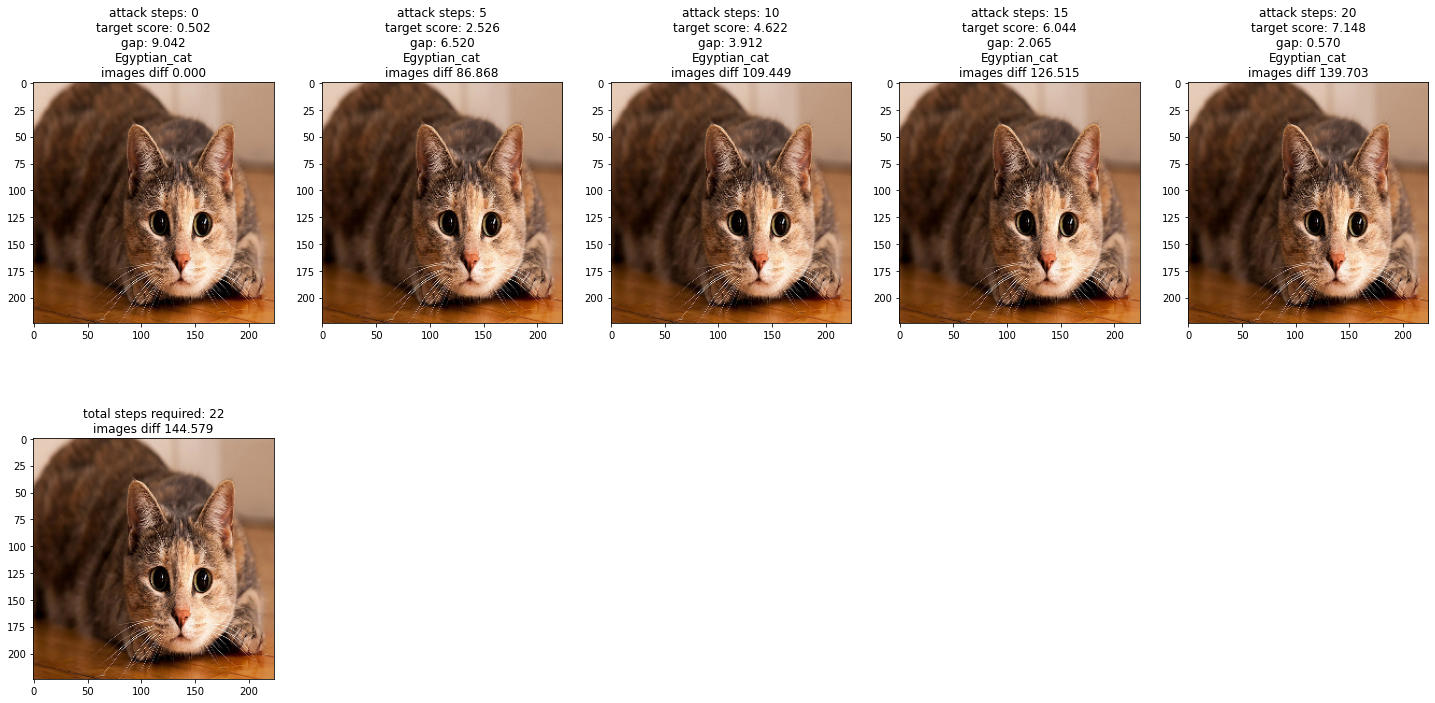

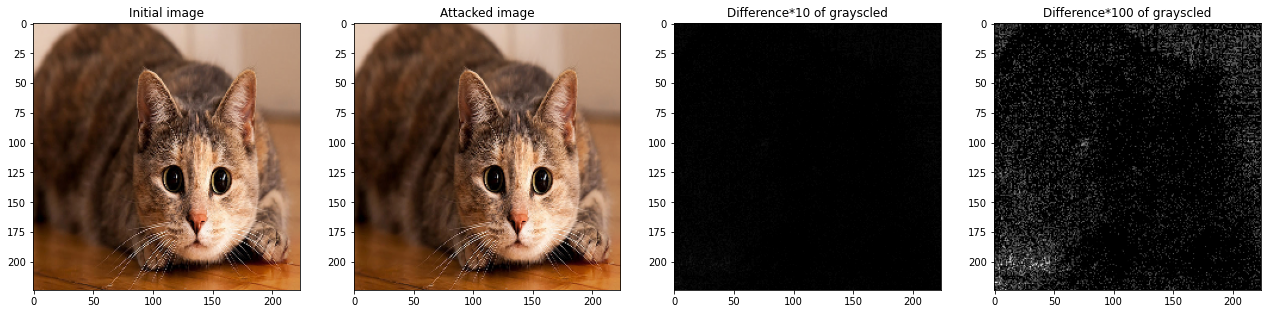

In [12]:
attack_and_draw(False, convnext_model, "https://klike.net/uploads/posts/2019-06/1559798617_1.jpg", 20, 50)

Targeting class: water_ouzel, dipper


  0%|          | 0/50 [00:00<?, ?it/s]

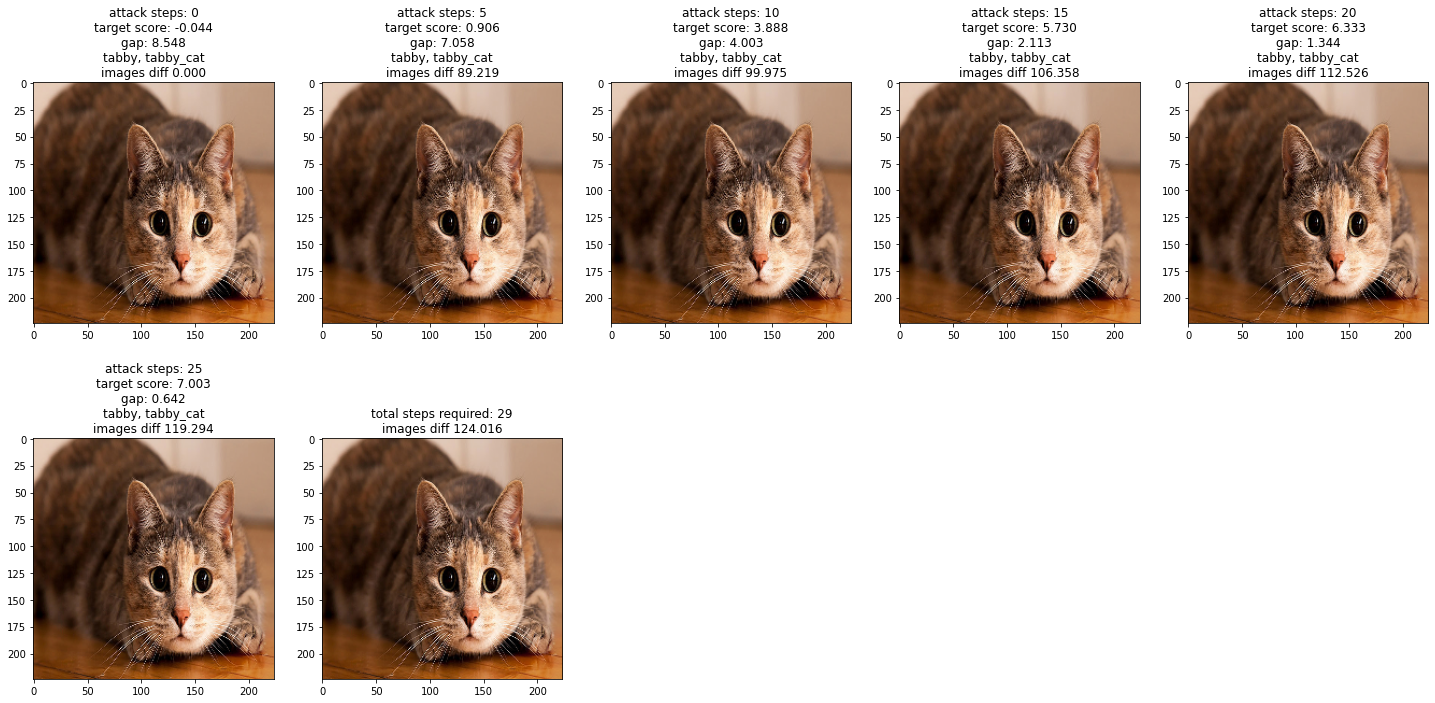

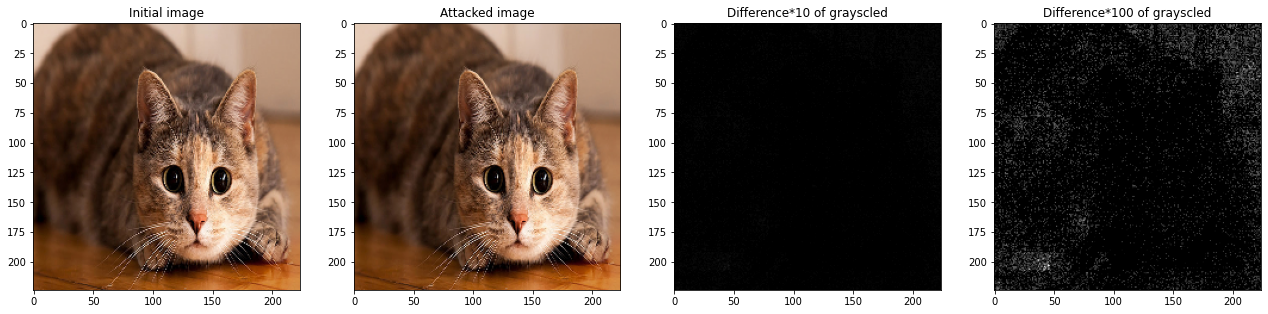

In [13]:
attack_and_draw(False, swin_model, "https://klike.net/uploads/posts/2019-06/1559798617_1.jpg", 20, 50)

Targeting class: water_ouzel, dipper


  0%|          | 0/300 [00:00<?, ?it/s]

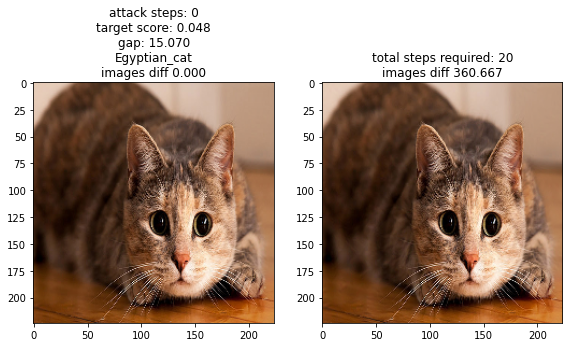

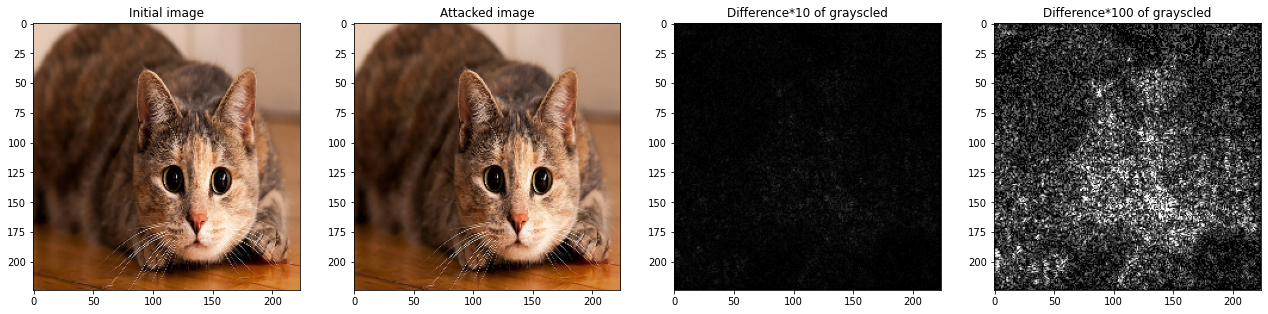

In [14]:
attack_and_draw(True, resnet_model, "https://klike.net/uploads/posts/2019-06/1559798617_1.jpg", 20, 300)

## Download mini imagenet

In [15]:
!pip install -q kaggle

from google.colab import files
files.upload()

!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json


In [16]:
!kaggle datasets download -d ifigotin/imagenetmini-1000

100% 3.91G/3.92G [01:00<00:00, 91.9MB/s]
100% 3.92G/3.92G [01:00<00:00, 69.2MB/s]


In [17]:
!unzip -qq /content/imagenetmini-1000.zip

In [18]:
import glob
import random

pics = []

for path in glob.glob('/content/imagenet-mini/val/*'):
    pics.extend(glob.glob(path + '/*'))

random.shuffle(pics)

## Some analysis

In [24]:
def postprocess_attack(initial_image, attacked_image, steps, err):
    if err is not None:
        raise err
    
    diff = get_images_diff(initial_image, attacked_image)
    return steps, diff

convnext_steps, convnext_diffs = [], []
swin_steps, swin_diffs = [], []
resnet_steps, resnet_diffs = [], []


for image in ntqdm(pics[:100]):
    image = Image.open(image)
    shape = np.asarray(image).shape
    if len(shape) != 3 or shape[-1] != 3:
        continue
    target_class = random.randint(0, 999)
    
    convnext_step, convnext_diff = postprocess_attack(*make_attack(False, convnext_model, image, target_class, axs_iter=None, max_steps=1000))
    convnext_steps.append(convnext_step)
    convnext_diffs.append(convnext_diff)

    swin_step, swin_diff = postprocess_attack(*make_attack(False, swin_model, image, target_class, axs_iter=None, max_steps=1000))
    swin_steps.append(swin_step)
    swin_diffs.append(swin_diff)

    resnet_step, resnet_diff = postprocess_attack(*make_attack(True, resnet_model, image, target_class, axs_iter=None, max_steps=1000))
    resnet_steps.append(resnet_step)
    resnet_diffs.append(resnet_diff)


  0%|          | 0/100 [00:00<?, ?it/s]

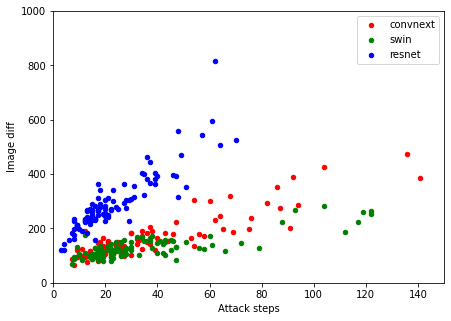

In [29]:
plt.figure(figsize=(7, 5))

s=20
plt.scatter(convnext_steps, convnext_diffs, c='r', label='convnext', s=s)
plt.scatter(swin_steps, swin_diffs, c='g', label='swin', s=s)
plt.scatter(resnet_steps, resnet_diffs, c='b', label='resnet', s=s)

plt.xlabel('Attack steps')
plt.ylabel('Image diff')

plt.xlim(0, 150)
plt.ylim(0, 1000)

plt.legend()

In [30]:
print('Average convnext attack steps:', np.array(convnext_steps).mean())
print('Average swin attack steps:', np.array(swin_steps).mean())
print('Average resnet attack steps:', np.array(resnet_steps).mean())

Average convnext attack steps: 38.05102040816327
Average swin attack steps: 35.142857142857146
Average resnet attack steps: 25.03061224489796


In [31]:
print('Average convnext image diff:', np.array(convnext_diffs).mean())
print('Average swin image diff:', np.array(swin_diffs).mean())
print('Average resnet image diff:', np.array(resnet_diffs).mean())

Average convnext image diff: 172.12066996159726
Average swin image diff: 130.8309854552704
Average resnet image diff: 310.15476450764544


Выводы:

1. На resnet приходится дальше всего отходить от исходной картинки, но разница все еще незаметна глазу.
2. При этом на resnet уходит меньше всего шагов атаки, что может говорить о том, что на практике такую сеть проще атаковать
3. convnext показывает себя похожим на swin, но устойчивее по обеим характеристикам

Доп чтение - https://arxiv.org/abs/2209.06953

В статье convnext оказывается достаточно стабильной моделью, но самой статье 2 недели (preprint), там что-то сложное с метриками и я нашел ее только ночью уже после написания вывода :)

## Bonus analysis

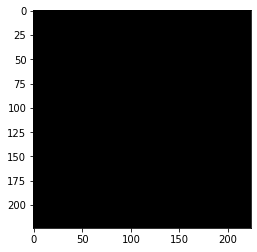

In [ ]:
zero_image = np.zeros((224, 224, 3))
plt.imshow(zero_image)
plt.show()

In [ ]:
convnext_steps, convnext_diffs = [], []
swin_steps, swin_diffs = [], []
resnet_steps, resnet_diffs = [], []


for i in ntqdm(range(10)):
    image = zero_image
    target_class = random.randint(0, 999)
    
    convnext_step, convnext_diff = postprocess_attack(*make_attack(False, convnext_model, image, target_class, axs_iter=None, max_steps=1000))
    convnext_steps.append(convnext_step)
    convnext_diffs.append(convnext_diff)

    swin_step, swin_diff = postprocess_attack(*make_attack(False, swin_model, image, target_class, axs_iter=None, max_steps=1000))
    swin_steps.append(swin_step)
    swin_diffs.append(swin_diff)

    resnet_step, resnet_diff = postprocess_attack(*make_attack(True, resnet_model, image, target_class, axs_iter=None, max_steps=1000))
    resnet_steps.append(resnet_step)
    resnet_diffs.append(resnet_diff)

  0%|          | 0/10 [00:00<?, ?it/s]

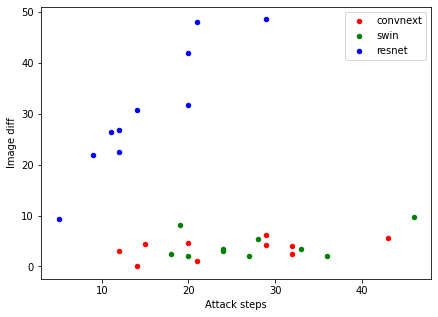

In [ ]:
plt.figure(figsize=(7, 5))

s=20
plt.scatter(convnext_steps, convnext_diffs, c='r', label='convnext', s=s)
plt.scatter(swin_steps, swin_diffs, c='g', label='swin', s=s)
plt.scatter(resnet_steps, resnet_diffs, c='b', label='resnet', s=s)

plt.xlabel('Attack steps')
plt.ylabel('Image diff')
plt.legend()

Выводы:

Все те же, что и в прошлый раз, но заметим, какой маленький diff. Это значит, что приводя картинку к рандомному классу мы не отличим ее глазами от черного :)

От этого можно защититься служебным классом 